In [56]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [57]:
from sklearn.model_selection import train_test_split
X_features = card_df.iloc[:, 1:-1]
y_target = card_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test, pred_proba)
    print('Confusion Matrix')
    print(confusion)

    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [59]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [60]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=64, n_jobs=-1, boost_from_average=False, verbose= -1)
print('*Evaluation After Processing Data by LightGBM*')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

*Evaluation After Processing Data by LightGBM*
Confusion Matrix
[[85290     5]
 [   36   112]]
Accuracy: 0.9995, Precision: 0.9573, Recall: 0.7568,    F1: 0.8453, AUC:0.9788


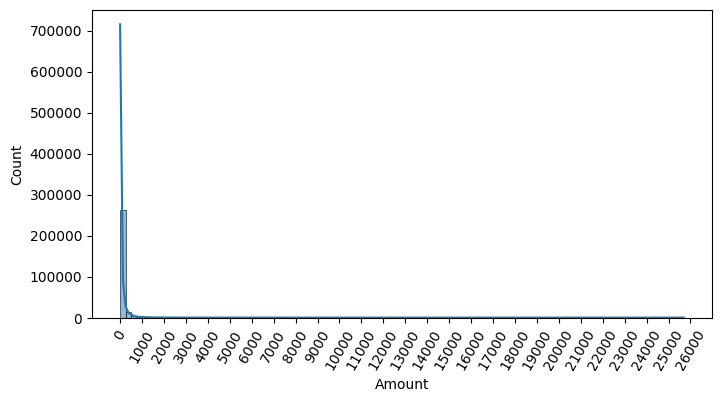

In [61]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
amount_n = scaler.fit_transform(card_df['Amount'].values.reshape(-1, 1))
card_df.drop(['Time','Amount'], axis=1)
card_df.insert(0, 'Amount_Scaled', amount_n)

In [63]:
X_features = card_df.iloc[:, :-1]
y_target = card_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
print('*Evaluation After Processing Data Variation by LightGBM*')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

*Evaluation After Processing Data Variation by LightGBM*
Confusion Matrix
[[85291     4]
 [   36   112]]
Accuracy: 0.9995, Precision: 0.9655, Recall: 0.7568,    F1: 0.8485, AUC:0.9792


<AxesSubplot: >

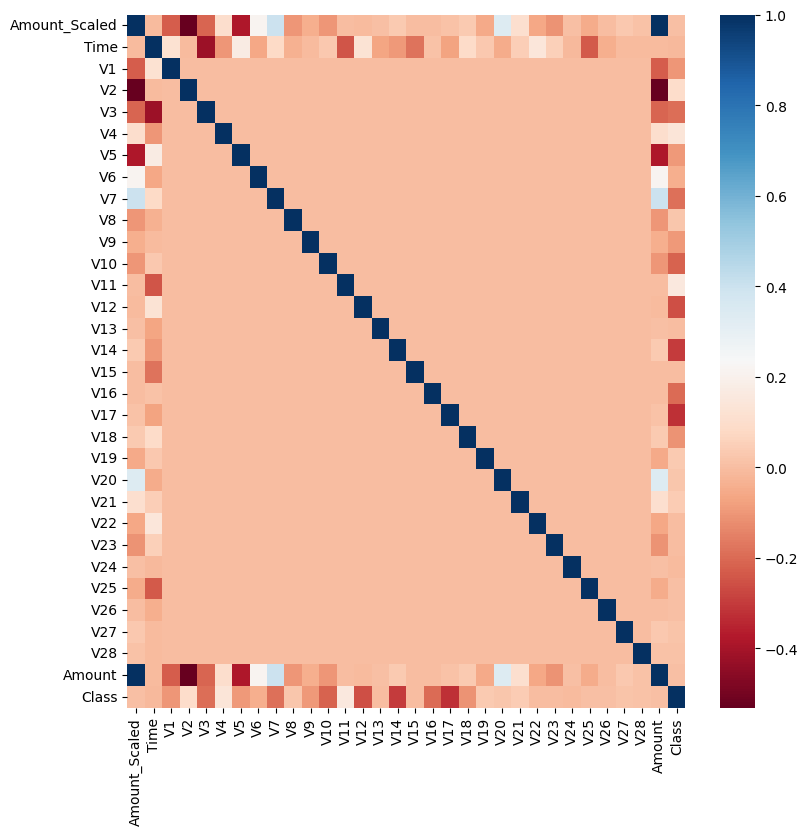

In [64]:
plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [65]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('outlier data index:', outlier_index)

outlier data index: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [66]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

In [67]:
card_df = get_preprocessed_df(card_df)
X_features = card_df.iloc[:, :-1]
y_target = card_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
print('*Evaluation After Processing Data Outlier by LightGBM*')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

*Evaluation After Processing Data Outlier by LightGBM*
Confusion Matrix
[[85291     4]
 [   27   119]]
Accuracy: 0.9996, Precision: 0.9675, Recall: 0.8151,    F1: 0.8848, AUC:0.9794


In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):

    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    

    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

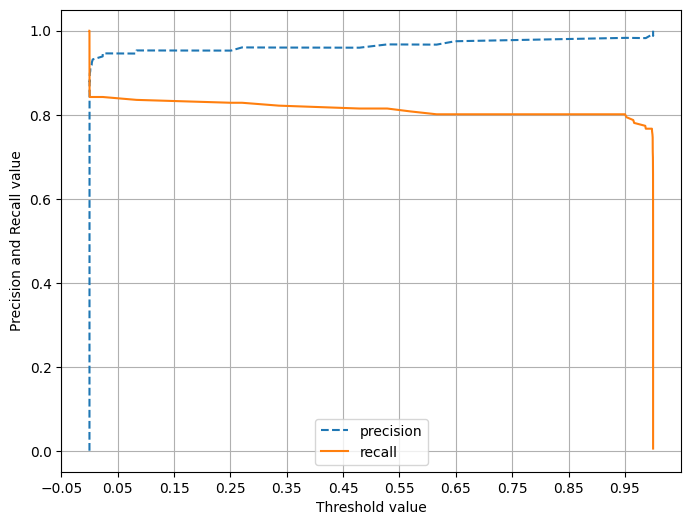

In [69]:
precision_recall_curve_plot( y_test, lgbm_clf.predict_proba(X_test)[:, 1] )